In [1]:
import cfp
import scanpy as sc
import anndata as ad
import numpy as np
import os

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
combosciplex_color_dict = {
    'Alvespimycin+Pirarubicin': '#f2d7d5',
    'Cediranib+PCI-34051': '#cd6155',
    'Dacinostat+Danusertib': '#641e16',
    'Dacinostat+Dasatinib': '#ebdef0',
    'Dacinostat+PCI-34051': '#76448a',
    'Givinostat+Carmofur': '#8e3101',
    'Givinostat+Cediranib': '#d4e6f1',
    'Givinostat+Crizotinib': '#2471a3',
    'Givinostat+Curcumin': '#d1f2eb',
    'Givinostat+Dasatinib': '#48c9b0',
    'Givinostat+SRT1720': '#EB984E',
    'Givinostat+SRT2104': '#16a085',
    'Givinostat+Sorafenib': '#fcf3cf',
    'Givinostat+Tanespimycin': '#b7950b',
    'Panobinostat+Alvespimycin': '#fad7a0',
    'Panobinostat+Crizotinib': '#8E1382',
    'Panobinostat+Curcumin': '#f8c471',
    'Panobinostat+Dasatinib': '#ce606c',
    'Panobinostat+PCI-34051': '#795548',
    'Panobinostat+SRT1720': '#22bb34',
    'Panobinostat+SRT2104': '#8D6E63',
    'Panobinostat+SRT3025': '#9d8303',
    'Panobinostat+Sorafenib': '#d7fdfd',
    'SRT2104+Alvespimycin': '#7e5109',
    'SRT3025+Cediranib': '#f4d03f',
    'control+Alvespimycin': '#b7950b',
    'control+Dacinostat': '#d6a5fa',
    'control+Dasatinib': '#2d62a3',
    'control+Givinostat': '#117864',
    'control+Panobinostat': '#b1cd3f',
    'control+SRT2104': '#af601a',
    'control': '#000000',
    'not ood': '#B6B6B6',
    'seen':'#B6B6B6',
    'other':'#B6B6B6',
}


In [3]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/analysis/combosciplex/embedding"
fig_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/combosciplex/embedding"

In [4]:
split = 3
model_name = "vibrant-universe-9"

In [5]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"
adata_train = sc.read_h5ad(adata_train_path)
adata_test = sc.read_h5ad(adata_test_path)
adata_ood = sc.read_h5ad(adata_ood_path)
    

In [6]:
def prepare_data(adata_train, adata_test, adata_ood):
    
    adata_tmp =  adata_train[adata_train.obs["Drug1"].drop_duplicates().index]
    ecfp_dict = {drug: adata_tmp[adata_tmp.obs["Drug1"]==drug].obsm["ecfp_drug_1"] for drug in adata_tmp.obs["Drug1"]}

    adata_tmp =  adata_train[adata_train.obs["Drug2"].drop_duplicates().index]
    ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["Drug2"]==drug].obsm["ecfp_drug_2"] for drug in adata_tmp.obs["Drug2"]})

    adata_tmp =  adata_ood[adata_ood.obs["Drug1"].drop_duplicates().index]
    ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["Drug1"]==drug].obsm["ecfp_drug_1"] for drug in adata_tmp.obs["Drug1"]})

    adata_tmp =  adata_ood[adata_ood.obs["Drug2"].drop_duplicates().index]
    ecfp_dict.update({drug: adata_tmp[adata_tmp.obs["Drug2"]==drug].obsm["ecfp_drug_2"] for drug in adata_tmp.obs["Drug2"]})

        
    adata_train.uns['ecfp_rep'] = ecfp_dict
    adata_test.uns['ecfp_rep'] = ecfp_dict
    adata_ood.uns['ecfp_rep'] = ecfp_dict
    return adata_train, adata_test, adata_ood

adata_train, adata_test, adata_ood = prepare_data(adata_train, adata_test, adata_ood)

In [7]:
adata_ood_ctrl = adata_ood[adata_ood.obs["condition"]=="control"]
adata_test_ctrl = adata_test[adata_test.obs["condition"]=="control"]
adata_ood_ctrl.obs["control"] = True
adata_test_ctrl.obs["control"] = True
covariate_data_ood = adata_ood[adata_ood.obs["condition"]!="control"].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[adata_test.obs["condition"]!="control"].obs.drop_duplicates(subset=["condition"])

/tmp/ipykernel_988443/3998593493.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ood_ctrl.obs["control"] = True
/tmp/ipykernel_988443/3998593493.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test_ctrl.obs["control"] = True


In [8]:
cf = cfp.model.CellFlow.load(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/{model_name}_CellFlow.pkl")

In [9]:
condition_embedding_ood = cf.get_condition_embedding(covariate_data=covariate_data_ood, condition_id_key="condition", rep_dict=adata_train.uns)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 7/7 [00:00<00:00, 12.99it/s]


In [10]:
condition_embedding_train = cf.get_condition_embedding(covariate_data=covariate_data_test, condition_id_key="condition", rep_dict=adata_train.uns)

/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/data/_datamanager.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _covariate_data["cell_index"] = _covariate_data.index
100%|██████████| 24/24 [00:00<00:00, 1288.97it/s]


In [11]:
import pandas as pd
condition_embs = pd.concat((condition_embedding_ood, condition_embedding_train), )

In [12]:
condition_embedding_train["type"] = "seen"
condition_embedding_ood["type"] = "unseen"

In [13]:
cond_embedding = pd.concat((condition_embedding_train, condition_embedding_ood))

In [14]:
df_obs = pd.read_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/combosciplex_obs.csv")

In [15]:
df_obs.head()

,Cell,sample,Size_Factor,n.umi,RT_well,Drug1,Drug2,Well,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,condition,pathway1,pathway2,split,control,cell_type
0,A01_A02_RT_BC_10_Lig_BC_18,sciPlex_theis,0.533816,1433,RT_10,control,Panobinostat,A10,1004,1004,1433.0,51.0,3.558967,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
1,A01_A02_RT_BC_10_Lig_BC_25,sciPlex_theis,0.539404,1448,RT_10,control,Panobinostat,A10,1062,1062,1448.0,53.0,3.660221,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
2,A01_A02_RT_BC_10_Lig_BC_48,sciPlex_theis,0.532326,1429,RT_10,control,Panobinostat,A10,1063,1063,1429.0,39.0,2.729181,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
3,A01_A02_RT_BC_10_Lig_BC_51,sciPlex_theis,1.461754,3924,RT_10,control,Panobinostat,A10,2412,2411,3923.0,215.0,5.480500,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549
4,A01_A02_RT_BC_10_Lig_BC_70,sciPlex_theis,0.418708,1124,RT_10,control,Panobinostat,A10,834,832,1122.0,48.0,4.278075,1,control+Panobinostat,Vehicle,HDAC inhibitor,train,0,A549


In [16]:
drug_to_pathway = pd.read_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/drug_to_pathway.csv")

In [17]:
drug_to_pathway_dict = dict(zip(drug_to_pathway['Unnamed: 0'], drug_to_pathway['pathway']))
drug_to_pathway_dict

{'control': 'Vehicle',
 'Cediranib': 'EGFR inhibitor',
 'Givinostat': 'HDAC inhibitor',
 'Panobinostat': 'HDAC inhibitor',
 'Dacinostat': 'HDAC inhibitor',
 'Alvespimycin': 'Protein folding & Protein degradation',
 'SRT2104': 'Sirtuin inhibitor',
 'SRT3025': 'Sirtuin inhibitor',
 'PCI-34051': 'HDAC inhibitor',
 'SRT1720': 'Sirtuin inhibitor',
 'Sorafenib': 'EGFR inhibitor',
 'Danusertib': 'Cell cycle regulation',
 'Dasatinib': 'EGFR inhibitor',
 'Tanespimycin': 'Protein folding & Protein degradation',
 'Carmofur': 'DNA damage & DNA repair',
 'Crizotinib': 'EGFR inhibitor',
 'Pirarubicin': 'DNA damage & DNA repair',
 'Curcumin': 'Sirtuin inhibitor'}

In [18]:
cond_embedding["condition"] = cond_embedding.index 

In [19]:
cond_embedding["drug1"] = cond_embedding.apply(lambda x: x["condition"].split("+")[0], axis=1)
cond_embedding["drug2"] = cond_embedding.apply(lambda x: x["condition"].split("+")[1], axis=1)

In [20]:
cond_embedding["pathway1"] = cond_embedding["drug1"].map(drug_to_pathway_dict)
cond_embedding["pathway2"] = cond_embedding["drug2"].map(drug_to_pathway_dict)

In [21]:
cond_embedding["pathway"] = cond_embedding["pathway1"] + " and " + cond_embedding["pathway2"]

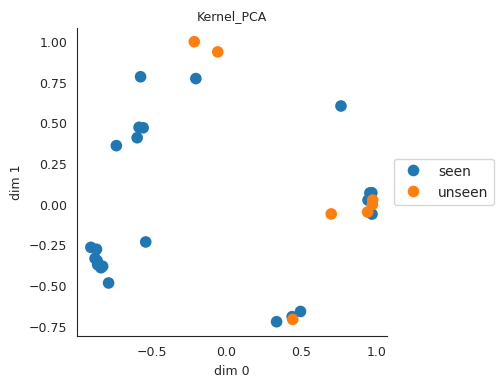

In [22]:
from cfp.plotting import plot_condition_embedding
fig = plot_condition_embedding(cond_embedding, embedding="Kernel_PCA", hue="type", circle_size=70)

In [23]:
cond_embedding

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,type,condition,drug1,drug2,pathway1,pathway2,pathway
condition,,,,,,,,,,,,,,,,,,,,,
control+Panobinostat,1.025319,-0.818403,0.270321,-0.870398,-0.882923,0.333730,0.862041,0.640226,-1.184063,0.648805,...,0.674371,-0.387452,-0.120841,seen,control+Panobinostat,control,Panobinostat,Vehicle,HDAC inhibitor,Vehicle and HDAC inhibitor
Dacinostat+PCI-34051,0.210952,-0.097073,0.902016,-0.179585,-0.177855,1.008131,0.069380,0.038209,-0.098525,0.764381,...,0.710290,-0.937868,0.217775,seen,Dacinostat+PCI-34051,Dacinostat,PCI-34051,HDAC inhibitor,HDAC inhibitor,HDAC inhibitor and HDAC inhibitor
Panobinostat+PCI-34051,1.093194,-0.762913,-0.089365,-0.871453,-0.914158,-0.023252,0.874213,0.695693,-1.018796,0.268436,...,0.865017,-0.015217,-0.288871,seen,Panobinostat+PCI-34051,Panobinostat,PCI-34051,HDAC inhibitor,HDAC inhibitor,HDAC inhibitor and HDAC inhibitor
Givinostat+Cediranib,-0.537322,0.749313,0.692976,0.764015,0.924071,0.391257,-0.824418,-0.739817,0.743478,-0.066497,...,-0.059884,-0.563838,0.902490,seen,Givinostat+Cediranib,Givinostat,Cediranib,HDAC inhibitor,EGFR inhibitor,HDAC inhibitor and EGFR inhibitor
Dacinostat+Danusertib,0.177959,-0.028301,1.340915,-0.182421,-0.186620,1.318909,0.088785,0.027348,-0.178162,1.169875,...,0.639092,-1.415988,0.190284,seen,Dacinostat+Danusertib,Dacinostat,Danusertib,HDAC inhibitor,Cell cycle regulation,HDAC inhibitor and Cell cycle regulation
Panobinostat+Dasatinib,1.070834,-0.770694,-0.174150,-0.849702,-0.875046,0.067438,0.876193,0.629593,-1.210206,0.660029,...,0.361092,-0.020638,-0.323916,seen,Panobinostat+Dasatinib,Panobinostat,Dasatinib,HDAC inhibitor,EGFR inhibitor,HDAC inhibitor and EGFR inhibitor
Givinostat+Tanespimycin,-1.059257,0.132334,-0.050799,0.296199,0.539065,-0.296214,-0.823748,-0.339672,0.359315,-0.574939,...,-0.728668,0.303316,0.037548,seen,Givinostat+Tanespimycin,Givinostat,Tanespimycin,HDAC inhibitor,Protein folding & Protein degradation,HDAC inhibitor and Protein folding & Protein d...
Alvespimycin+Pirarubicin,-2.189560,-0.301492,-1.380652,-0.170484,0.145099,-1.783106,-0.357526,0.088083,1.823516,-2.019922,...,-2.160711,1.725146,-0.810608,seen,Alvespimycin+Pirarubicin,Alvespimycin,Pirarubicin,Protein folding & Protein degradation,DNA damage & DNA repair,Protein folding & Protein degradation and DNA ...
Givinostat+Sorafenib,0.158804,1.443292,0.309580,1.877259,0.478001,0.681840,-0.338655,-2.064190,-0.092439,0.367342,...,-1.093363,-0.015106,1.494773,seen,Givinostat+Sorafenib,Givinostat,Sorafenib,HDAC inhibitor,EGFR inhibitor,HDAC inhibitor and EGFR inhibitor


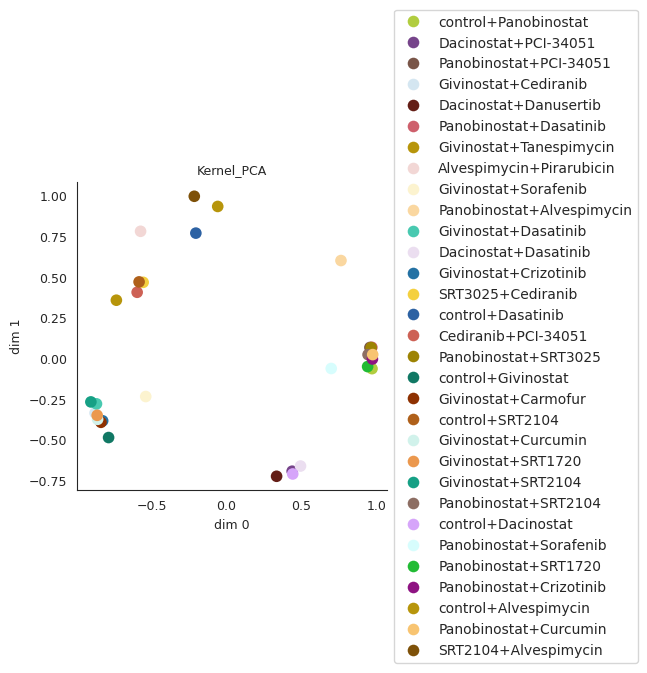

In [24]:
combosciplex_color_dict["seen"] = "#D3D3D3"
fig = plot_condition_embedding(cond_embedding, embedding="Kernel_PCA", hue="condition", col_dict=combosciplex_color_dict, circle_size=70)
fig.savefig(os.path.join(fig_dir, "all_conditions.pdf"))

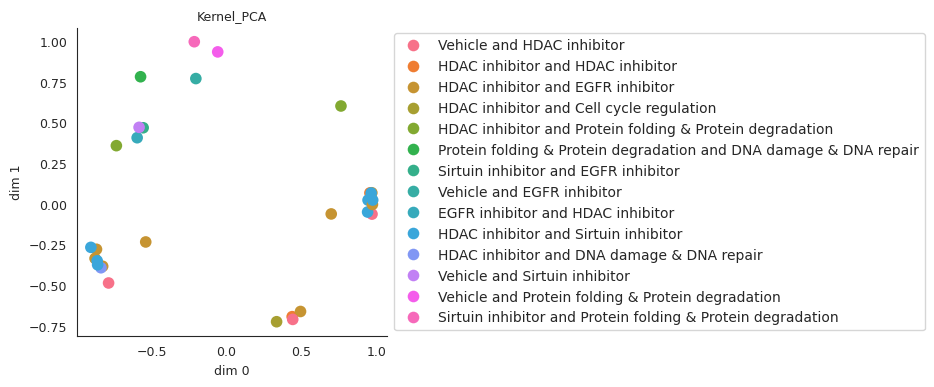

In [25]:
fig = plot_condition_embedding(cond_embedding, embedding="Kernel_PCA", hue="pathway", circle_size=70)
fig.savefig(os.path.join(fig_dir, "pathway.pdf"))

In [26]:
cond_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,type,condition,drug1,drug2,pathway1,pathway2,pathway
condition,,,,,,,,,,,,,,,,,,,,,
control+Panobinostat,1.025319,-0.818403,0.270321,-0.870398,-0.882923,0.333730,0.862041,0.640226,-1.184063,0.648805,...,0.674371,-0.387452,-0.120841,seen,control+Panobinostat,control,Panobinostat,Vehicle,HDAC inhibitor,Vehicle and HDAC inhibitor
Dacinostat+PCI-34051,0.210952,-0.097073,0.902016,-0.179585,-0.177855,1.008131,0.069380,0.038209,-0.098525,0.764381,...,0.710290,-0.937868,0.217775,seen,Dacinostat+PCI-34051,Dacinostat,PCI-34051,HDAC inhibitor,HDAC inhibitor,HDAC inhibitor and HDAC inhibitor
Panobinostat+PCI-34051,1.093194,-0.762913,-0.089365,-0.871453,-0.914158,-0.023252,0.874213,0.695693,-1.018796,0.268436,...,0.865017,-0.015217,-0.288871,seen,Panobinostat+PCI-34051,Panobinostat,PCI-34051,HDAC inhibitor,HDAC inhibitor,HDAC inhibitor and HDAC inhibitor
Givinostat+Cediranib,-0.537322,0.749313,0.692976,0.764015,0.924071,0.391257,-0.824418,-0.739817,0.743478,-0.066497,...,-0.059884,-0.563838,0.902490,seen,Givinostat+Cediranib,Givinostat,Cediranib,HDAC inhibitor,EGFR inhibitor,HDAC inhibitor and EGFR inhibitor
Dacinostat+Danusertib,0.177959,-0.028301,1.340915,-0.182421,-0.186620,1.318909,0.088785,0.027348,-0.178162,1.169875,...,0.639092,-1.415988,0.190284,seen,Dacinostat+Danusertib,Dacinostat,Danusertib,HDAC inhibitor,Cell cycle regulation,HDAC inhibitor and Cell cycle regulation


In [27]:
cond_embedding["condition_adapted"] = cond_embedding.apply(lambda x: x["condition"] if x["type"]=="unseen" else "other", axis=1)

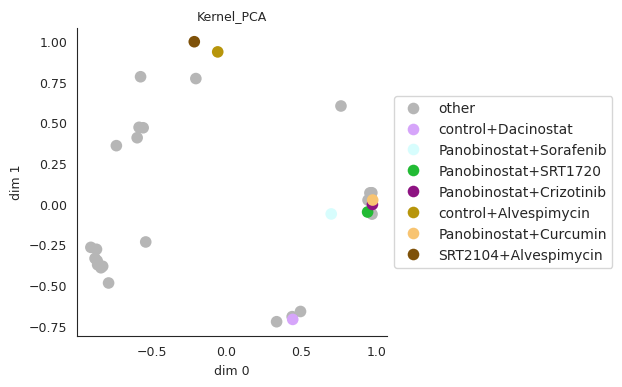

In [28]:

fig = plot_condition_embedding(cond_embedding, embedding="Kernel_PCA", hue="condition_adapted", col_dict=combosciplex_color_dict, circle_size=70)
fig.savefig(os.path.join(fig_dir, "embedding_ood.pdf"))

In [29]:
cond_embedding["contains_Panobinostat"] = cond_embedding.apply(lambda x: x["condition"] if "Panobinostat" in x["condition"] else "other", axis=1)

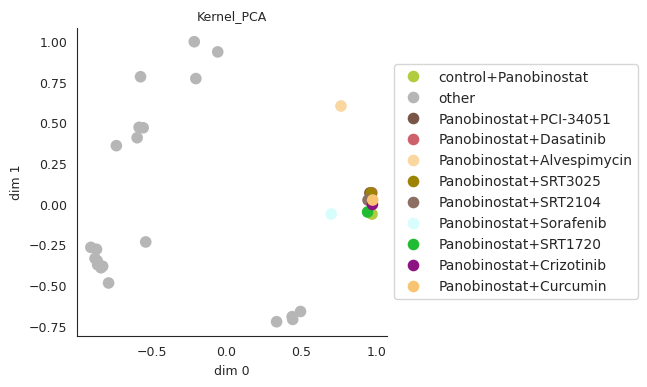

In [30]:
fig = plot_condition_embedding(cond_embedding, embedding="Kernel_PCA", hue="contains_Panobinostat", col_dict=combosciplex_color_dict, circle_size=70)
fig.savefig(os.path.join(fig_dir, "contains_panobinostat.pdf"))

In [31]:
cond_embedding["condition"] = cond_embedding.index
cond_embedding.to_csv(os.path.join(output_dir, "cond_embedding_split_3.csv"))